In [3]:
import sys
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
import seaborn as sns
import mdtraj as md
from natsort import natsorted

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from funcs_featurise import *
from funcs_db_assign import *
from funcs_indices import *
from funcs_plotting import *
from funcs_sample import *
from TrajData import TrajData
from MSMStudy import MSMStudy

In [4]:
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 16  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label
plt.rcParams['axes.titlesize'] = 18   # Font size for title

In [30]:
protein = 'abl'
key = 'abl-pdb-50ps' # Dataset key 
study = 'with_prior' # where the results are saved
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data') # base dir

hps_df = pd.read_csv(data_path/f'{protein}'/'msm'/f'{study}'/'hps.csv')
TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'), 
               ftraj_dir= data_path / f'{protein}'/ f'{key}' / 'ftrajs',
               dt=0.05,
               key=key)
study = MSMStudy(hps_table = hps_df,
                 traj_data = TD,
                 wk_dir = data_path/f'{protein}'/'msm'/f'{study}')
study.observation

Setting dataset <abl-pdb-50ps>. 
Number of raw trajectories: 749



,hp_id,time_consumed,is_sparse,ev_1,ev_2,ev_3,ev_4,ev_5,ev_6,ev_7,...,vamp2_std_2,vamp2_std_3,vamp2_std_4,vamp2_std_5,vamp2_std_6,vamp2_std_7,vamp2_std_8,vamp2_std_9,vamp2_std_10,vamp2_std_11
0,1,1074.410517,False,1.0,0.999890,0.999787,0.999782,0.999431,0.999369,0.997438,...,0.000140,0.000156,0.000186,0.000216,0.000257,0.000260,0.000290,0.000322,0.000335,0.003066
1,2,1013.094291,False,1.0,0.999886,0.999787,0.999762,0.999428,0.999368,0.997492,...,0.000135,0.000173,0.000192,0.000191,0.000224,0.000230,0.000256,0.000274,0.000279,0.003603
2,3,1017.254637,False,1.0,0.999891,0.999773,0.999725,0.999414,0.999363,0.997478,...,0.000178,0.000186,0.000219,0.000225,0.000256,0.000261,0.000279,0.000296,0.000310,0.000672
3,4,984.530003,False,1.0,0.999879,0.999758,0.999714,0.999405,0.999334,0.997464,...,0.000121,0.000171,0.000287,0.000222,0.000255,0.000262,0.000287,0.000306,0.000309,0.001657
4,5,3786.938161,False,1.0,0.999802,0.999065,0.998065,0.997963,0.997724,0.997167,...,0.000023,0.000032,0.000200,0.000305,0.000257,0.000259,0.000303,0.000339,0.000356,0.000374


In [31]:
study.hps_table

,hp_id,datasets,features,dt_out,time_cutoff,tica_lag_time,tica_stride,tica_dim,tica_kinetic_map,cluster_n,cluster_stride,cluster_max_iter,seed,markov_lag_time,markov_count_mode,markov_count_prior,msm_mode
0,1,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,1000,1000,1000,42,10,effective,True,bayesian
1,2,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,1000,1000,1000,42,20,effective,True,bayesian
2,3,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,1000,1000,1000,42,50,effective,True,bayesian
3,4,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,1000,1000,1000,42,100,effective,True,bayesian
4,5,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,2000,1000,1000,42,100,effective,True,bayesian
5,6,abl-pdb-50ps,dbdist dbdihed achelix aloop,0.05,100,1,1000,20,True,5000,1000,1000,42,100,effective,True,bayesian


In [32]:
study.set_hp_id(4)

Set dataset abl-pdb-50ps stride to 1
Loading MSM model id 4 from /home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/with_prior/4
{'hp_id': 4, 'datasets': 'abl-pdb-50ps', 'features': 'dbdist dbdihed achelix aloop', 'dt_out': 0.05, 'time_cutoff': 100, 'tica_lag_time': 1, 'tica_stride': 1000, 'tica_dim': 20, 'tica_kinetic_map': True, 'cluster_n': 1000, 'cluster_stride': 1000, 'cluster_max_iter': 1000, 'seed': 42, 'markov_lag_time': 100, 'markov_count_mode': 'effective', 'markov_count_prior': True, 'msm_mode': 'bayesian'}
Loading trajectories...
Loading models...
Done


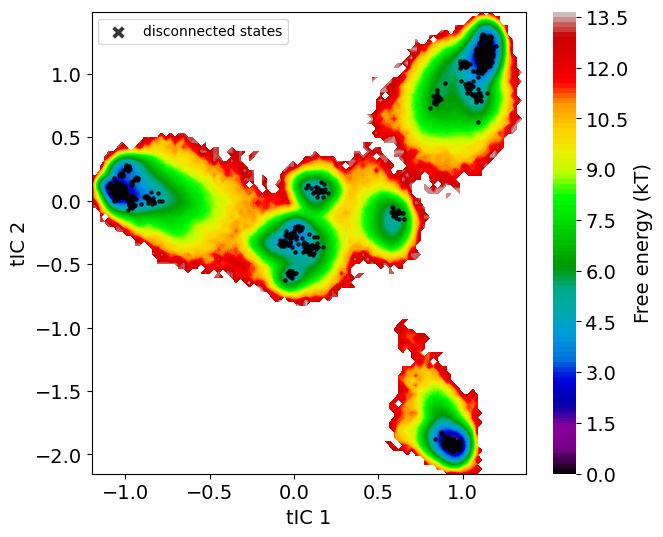

In [33]:
# Free energy surface with microstates 
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=20,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        savedir=study.fig_dir/'free_energy.svg'
        )

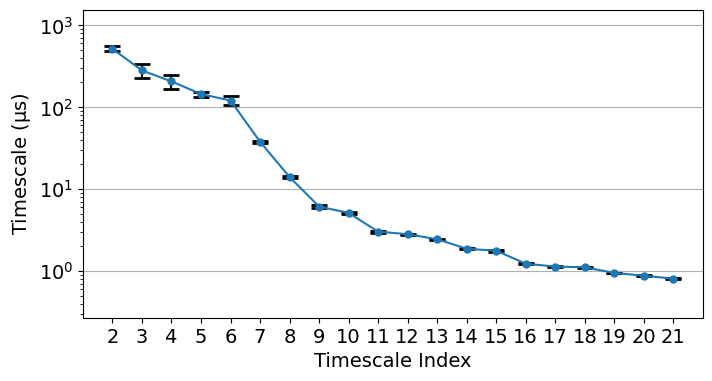

In [52]:
# Timescales 
plot_ts(timescales=study.baymsm_mod.timescales()[1], 
        #timescales=study.msm_mod.timescales(),
        n_ts = 20, 
        dt = study.hp_dict.dt_out, 
        savedir = study.fig_dir/'timescales.svg')

### Coarse-grain with PCCA

In [36]:
study.run_pcca(6)

/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:92: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],


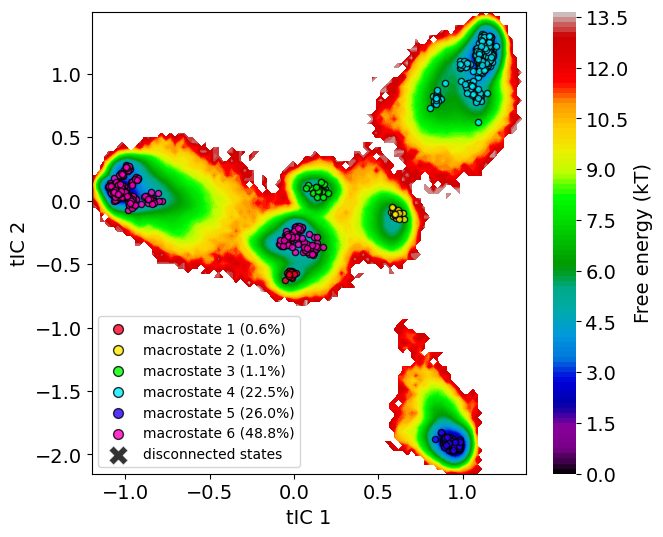

In [37]:
# Free energy surface with microstates colored by PCCA states
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=80,
        state_assignment=study.pcca_mod.assignments,
        n_states=study.pcca_n,
        state_population=study.pcca_mod.coarse_grained_stationary_probability,
        linewidth=1,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        d_centers_marker='X',
        legend_marker_sizes=[200, 200, 200, 200, 200, 200, 200],
        savedir = study.fig_dir/'pcca.svg')

In [45]:
# I may want to show the crystal structures in the free energy surface
# I load the crystals and featurise them here

crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])
print('Number of crystal structures:', len(crystal_files))

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, achelix_featuriser]
c_ftrajs_dict = {f.__name__.split('_')[0]:[f(traj=crystals, protein=protein)] for f in featurisers}
c_ftrajs, _ = TD.prepare_ftrajs(c_ftrajs_dict, stride=1, frame_no_cutoff=0, convert_dihed_ids=[1])
c_ttraj, dtraj, connected_d, c_disconnected_d, c_pcca_assignment = study.transform(c_ftrajs)

Number of crystal structures: 83
Preparing feature trajectories...


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]


In [42]:
# Load the precomputed Dunbrack states assignment 
# hdbscan_dist_group / hdbscan_dihed_group -- used hdbscan
# distgroup / dihedgroup -- used average-linkage hierachical clustering 

TD.load_ftrajs(key=key,
               feature_names=['hdbscan_dist_group', 'hdbscan_dihed_group'],)
distgroup, _ = TD.get_ftrajs(keys=key, 
                             dt_out=0.05, 
                             internal_names=['hdbscan_dist_group'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
dihedgroup, _ = TD.get_ftrajs(keys=key, 
                              dt_out=0.05, 
                              internal_names=['hdbscan_dihed_group'], 
                              time_cutoff=0,
                              convert_dihed_ids=None)
distgroup_cat = np.concatenate(distgroup).flatten()
dihedgroup_cat = np.concatenate(dihedgroup).flatten()

abl-pdb-50ps
Loading feature:  hdbscan_dist_group


100%|██████████| 749/749 [00:00<00:00, 9284.53it/s]


Loading feature:  hdbscan_dihed_group


100%|██████████| 749/749 [00:00<00:00, 9648.98it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 85411.86it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 52727.11it/s]


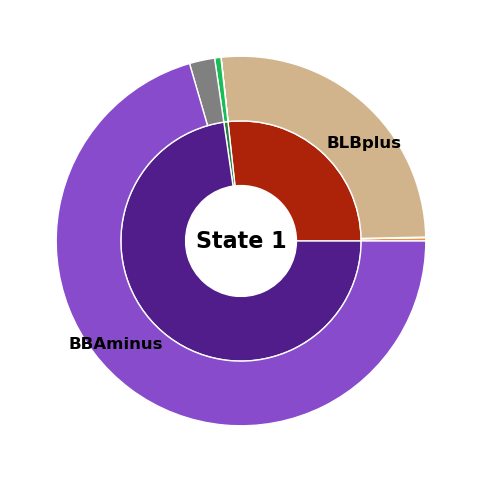

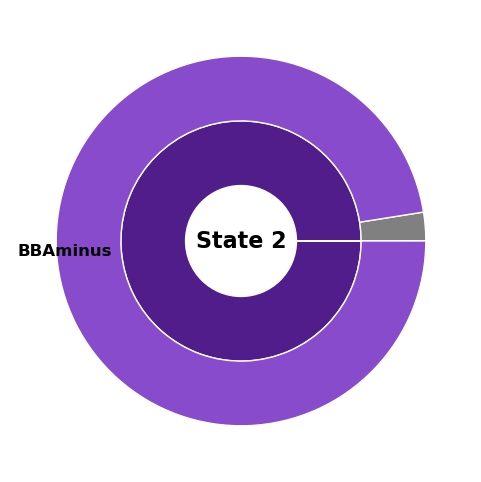

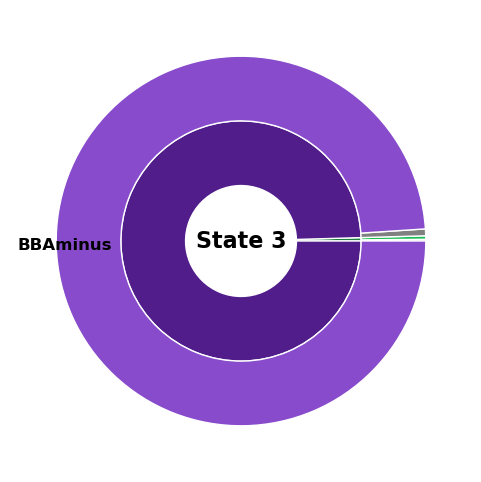

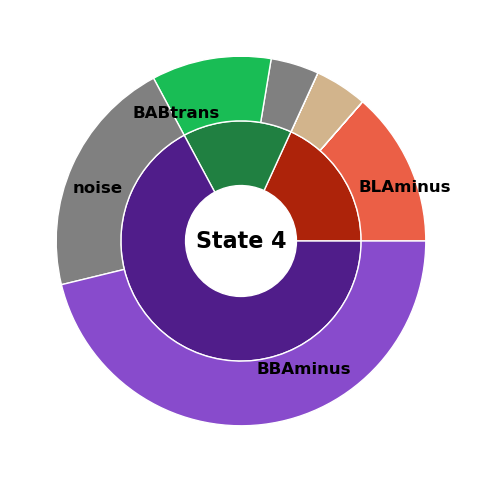

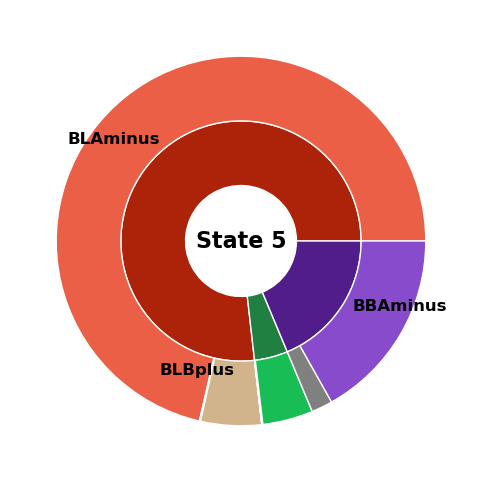

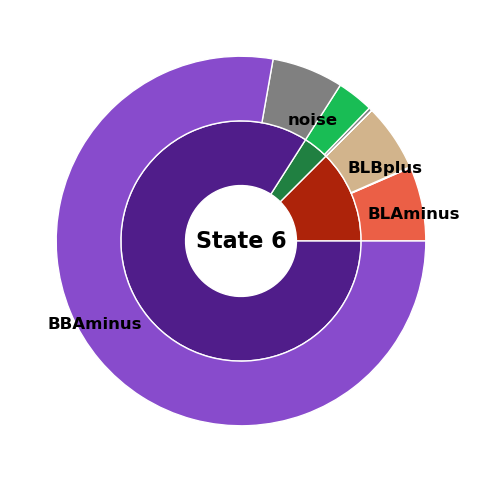

In [44]:
# Plot the Dunbrack state compostition for each macrostate
# Note - the color scheme haven't been changed yet
# They should match the palette used in VMD
# I also need to come up with a palette for Dunbrack states 

sim_ptraj_cat = np.array([study.micro_to_macro[d] if d in study.connected_states else -1 for d in study.dtraj_cat])

for state_i in range(study.pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    spatial_assignments, dihed_assignments = distgroup_cat[frame_indices], dihedgroup_cat[frame_indices]
    
    spatial_counts, dihed_counts = dunbrack_count(spatial_assignments, dihed_assignments)
    plot_dihed_pie(spatial_counts, dihed_counts, 
                   radius_size=0.35, show_legend=False, show_clusters=True,
                   title=f'State {state_i+1}', 
                   savedir=study.fig_dir/f'state_{state_i+1}_dihed.svg')

### Coarse-grained transition matrix and MFPT

In [47]:
# Compute MFPT matrix

mfpt = np.zeros([study.pcca_n, study.pcca_n])
mfpt_std = np.zeros([study.pcca_n, study.pcca_n])

for i in range(study.pcca_n):
    for j in range(study.pcca_n):
        mfpt[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).mean
        mfpt_std[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).std

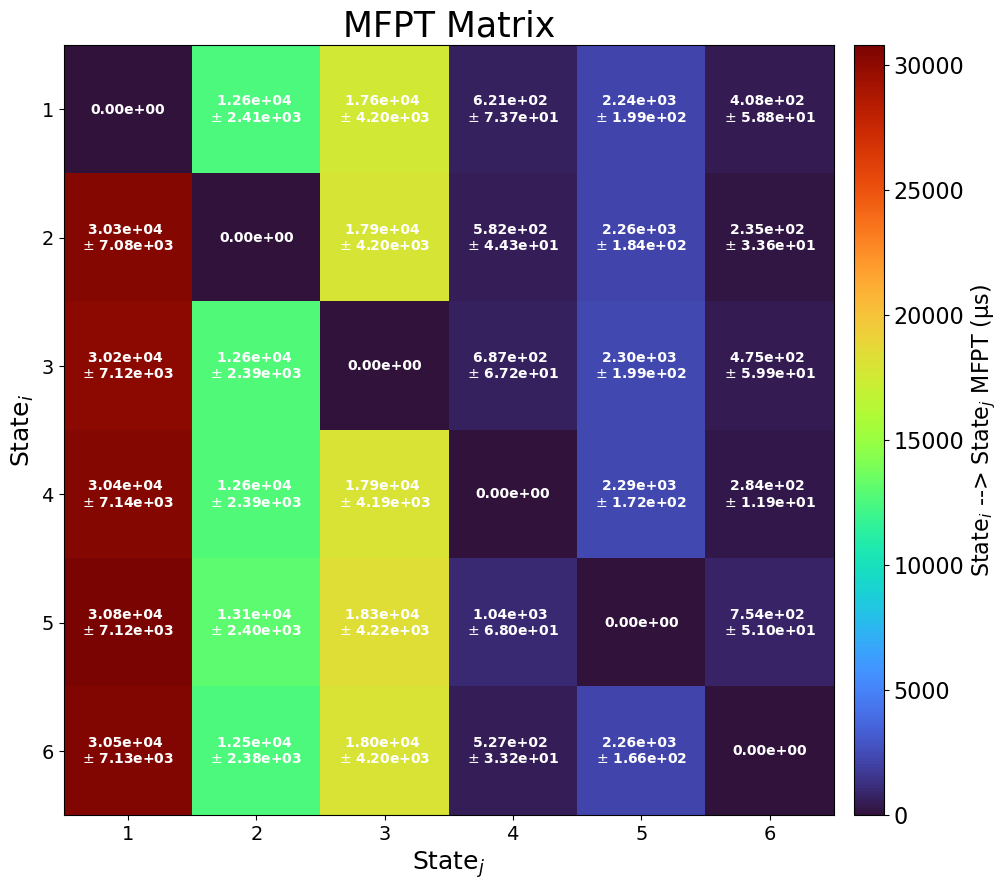

In [55]:
# MFPT matrix
plot_mfpt_matrix(mfpt = mfpt,
                 mfpt_err = mfpt_std, 
                 dt = study.hp_dict.dt_out,
                 text_f =".2e",
                 savedir = study.fig_dir/'mfpt_matrix.svg')

In [ ]:
# MFPT graph 
plot_pcca_graph(traj_all = study.ttraj_cat,
                traj_weights = np.concatenate(study.traj_weights, axis=0),
                c_centers = study.kmeans_centers[study.connected_states, :],
                c_centers_a = 0.5,
                c_centers_s = 50,
                matrix = mfpt,
                pcca_assignment = study.pcca_mod.assignments,
                stat_dist = study.msm_mod.stationary_distribution,
                savedir = study.fig_dir/'mfpt_graph.svg')

### Eigenvectors

In [ ]:
# Plot the top 10 eigenvectors 
# The max and min are shown in red and blue respectively
for ev_id in range(10):
    plot_ev(ev = study.msm_mod.eigenvectors_right()[:,ev_id+1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ],
            c_centers = study.kmeans_centers[study.connected_states,:],
            traj_all = study.ttraj_cat,
            traj_weights = np.concatenate(study.traj_weights,axis=0),
            title = f'eigenvector_{ev_id+2}',
            savedir = study.fig_dir/f'eigenvector_{ev_id+2}.svg')

### Sample pcca states and save examples

In [ ]:
# Sample from each macrostate 
n_sample = 100
for pcca_state in range(study.pcca_n):
    samples = study.sample_from_macrostate(n_sample = n_sample,
                                           macrostate_id = pcca_state,
                                           ci_cutoff = 0.8,
                                           weights ='equilibrium')  # weights based on stationary distribution
    study.save_samples(samples, 
                       fname = study.sample_dir/f'macrostate_{pcca_state}_{n_sample}_samples.pdb',
                       save_ids=True)

In [ ]:
# # Save samples for ML analysis 

# dir = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data/{protein}/msm/markov_priors/samples_ml')
# dir.mkdir(parents=True, exist_ok=True)
# ref = md.load(crystal_files[0])
# ref = ref.atom_slice(ref.top.select('mass>1.1'))
# ref.save(dir/'ref.pdb')

# with open(dir/f'samples.txt', 'w') as f:
#     f.writelines(f'macrostate,microstate,traj_id,frame_id\n')

# for pcca_state in range(study.pcca_n):
#     membership_cutoff = 0.8  # Only sample microstates that are committed to a macrostate

#     memberships = study.pcca_mod.memberships[:,pcca_state]
#     states_to_sample = memberships > membership_cutoff

#     stationary_distribution = study.msm_mod.stationary_distribution.copy()
#     stationary_distribution[~states_to_sample] = 0
#     sample_distribution = stationary_distribution / np.sum(stationary_distribution)

#     state_samples_count = sample_states_by_distribution(sample_distribution, study.connected_states, 1000)
#     samples = sample_frames_by_states(state_samples_count, study.dtrajs, mapping=study.mapping)
#     print(state_samples_count) # Print what microstates are sampled and how many samples from each 

#     with open(dir/f'samples.txt', 'a') as f:
#         sample_id = 0        
#         for state, n_samples in state_samples_count.items():
#             for i in range(n_samples):
#                 f.writelines(f'{pcca_state+1},{state},{samples[sample_id][0]},{samples[sample_id][1]}\n')
#                 sample_id += 1
#     save_samples(samples, 
#                  TD.datasets['pdb-1ns']['rtraj_files'], 
#                  dir/f'MS_{pcca_state+1}.pdb',
#                  reference=ref)

### Sample pcca extreme states

In [ ]:
# This may still work but I will need to update using the new methods 

with open(study.sample_dir/f'samples_ex.txt', 'w') as f:
    f.writelines(f'macrostate,microstate,traj_id,frame_id\n')

for state_i in range(study.pcca_n):
    memberships = study.pcca_mod.memberships[:,state_i]

    state_samples_count = {study.connected_states[np.argmax(memberships)] : 1}
    samples = sample_frames_by_states(state_samples_count, study.dtrajs, mapping=study.mapping)
    print(state_samples_count) 

    with open(study.sample_dir/f'samples_ex.txt', 'a') as f:
        sample_id = 0        
        for state, n_samples in state_samples_count.items():
            for i in range(n_samples):
                f.writelines(f'{state_i+1},{state},{samples[sample_id][0]},{samples[sample_id][1]}\n')
                sample_id += 1
    save_samples(samples, 
                 TD.datasets['pdb-1ns']['rtraj_files'], 
                 study.sample_dir/f'MS_{state_i+1}_ex.pdb')

### Sample eigenvector extreme states

In [ ]:
# This may still work but I will need to update using the new methods 

n_samples = 20
with open(study.sample_dir/f'samples_eigen_extremes.txt', 'w') as f:
    f.writelines(f'eigenvector,microstate,traj_id,frame_id\n')

for ev_id in range(10):
    ev = study.msm_mod.eigenvectors_right()[:,ev_id+1]

    ev_min_sample_count = {study.connected_states[np.argmin(ev)] : n_samples}
    ev_max_sample_count = {study.connected_states[np.argmax(ev)] : n_samples}
    print(ev_min_sample_count, ev_max_sample_count)

    samples_min = sample_frames_by_states(ev_min_sample_count, study.dtrajs, mapping=study.mapping)
    samples_max = sample_frames_by_states(ev_max_sample_count, study.dtrajs, mapping=study.mapping)

    with open(study.sample_dir/f'samples_eigen_extremes.txt', 'a') as f:
        for (state_min, n_samples),(state_max, n_samples) in zip(ev_min_sample_count.items(),ev_max_sample_count.items()):
            for i in range(n_samples):
                f.writelines(f'{ev_id+2}_min,{state_min},{samples_min[i][0]},{samples_max[i][1]}\n')
                f.writelines(f'{ev_id+2}_max,{state_max},{samples_min[i][0]},{samples_max[i][1]}\n')

    save_samples(samples_min, 
                 TD.datasets['pdb-1ns']['rtraj_files'], 
                 study.sample_dir/f'ev_{ev_id+1}_min.pdb')
    save_samples(samples_max, 
                 TD.datasets['pdb-1ns']['rtraj_files'], 
                 study.sample_dir/f'ev_{ev_id+1}_max.pdb')


### The highest flux pathways and the bottleneck states

In [ ]:
# I find the macrostates that are most likely to be the active and inactive states
# according to the FES and Dunbrack state decomposition
# I use a confidence to filter out the some microstates. The value can be adjusted

inactive_ms_id = 5
active_ms_id = 4

start_state_ids = np.where(study.pcca_mod.memberships[:,inactive_ms_id] > 0.99)[0]
end_state_ids = np.where(study.pcca_mod.memberships[:,active_ms_id] > 0.99)[0]
print(start_state_ids, end_state_ids)

In [ ]:
# Compute the tpt pathways 
tpt_activation = study.msm_mod.reactive_flux(start_state_ids, end_state_ids)
paths, pathfluxes = tpt_activation.pathways(fraction=1.0)

Identify the pathway with the highest flux

In [ ]:
max_flux_index = np.argmax(pathfluxes)
highest_flux_pathway = paths[max_flux_index]
highest_flux_value = pathfluxes[max_flux_index]
print('States in the highest flux pathway:', highest_flux_pathway)

Identify the minimum flux transition (the bottleneck states)

In [ ]:
path_fluxes = [tpt_activation.net_flux[highest_flux_pathway[i], highest_flux_pathway[i+1]]
               for i in range(len(highest_flux_pathway) - 1)]
bottleneck_index = np.argmin(path_fluxes)
bottleneck_state = highest_flux_pathway[bottleneck_index]
bottleneck_flux_value = path_fluxes[bottleneck_index]
print('Index of the bottleneck state:', bottleneck_index)

Generate samples from the highest flux trajectory.

In [ ]:
samples = simulated_traj_to_samples(highest_flux_pathway, study.dtrajs, mapping=None)

np.save(study.sample_dir/'highest_flux_traj_ids.npy', samples)

In [ ]:
cmap = plt.get_cmap('binary')
colors = cmap(np.linspace(0, 1, len(highest_flux_pathway)))

plot_fe(traj_all = study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers = study.kmeans_centers[highest_flux_pathway, :],
        c_centers_c = colors,
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 50,
        linewidth = 1,
        title = f'Highest flux pathway (flux = {highest_flux_value:.2e})',
        savedir= study.fig_dir/'highest_flux_path.svg')

In [ ]:
index_states = compute_index_states(study.dtrajs)
snapshot_ids = [index_states[state] for state in highest_flux_pathway]
state_dihedgroup_counts = []
for i in range(len(highest_flux_pathway)):
    assignment = np.concatenate([dihedgroup[id[0]][id[1]] for id in snapshot_ids[i]])
    counts = [np.count_nonzero([assignment == i]) for i in range(-1, 8)]
    state_dihedgroup_counts.append(counts)
dihedgroup_state_counts = np.array(state_dihedgroup_counts).T

In [ ]:
# Again I will need to update the color scheme 

x = list(range(len(highest_flux_pathway)))
dihed_colors = np.array([
                    (128/255, 128/255, 128/255),   # Gray
                    (235/255, 95/255, 70/255),     # Light Red
                    (240/255, 146/255, 58/255),    # Flamebright
                    (255/255, 214/255, 92/255),    # Light yellow
                    (255/255, 188/255, 214/255),   # Light pink
                    (210/255, 180/255, 140/255),   # Tan
                    (196/255, 79/255, 108/255),    # Strawberry
                    (25/255, 189/255, 85/255),     # Light Green
                    (136/255, 75/255, 204/255)])   # Light Purple
labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(len(highest_flux_pathway))
y = 0

for group_name, group_count, color in zip(labels, dihedgroup_state_counts, dihed_colors):
    p = ax.bar(x, group_count, width, label=group_name, bottom=bottom, color=color)
    y += p[bottleneck_index].get_height()
    bottom += group_count
print(y)
x = p[bottleneck_index].get_x() + p[bottleneck_index].get_width() / 2
ax.text(x, y*0.9, '*', ha='center', va='bottom', fontsize=25, color='k')
ax.annotate("Bottleneck", (x, y), xytext=(x, y*1.2),
            ha='center', color='k', fontsize=12)

ax.set_yticks([0, 20000, 40000, 60000, 80000])
ax.set_ylabel('Count')
ax.set_xlabel('Highest flux pathway state')
ax.legend(loc="upper left", fontsize=10)

plt.savefig(study.fig_dir/'highest_flux_pathway_bottleneck_state.svg', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
TD.load_ftrajs(key=key,
               feature_names=['dbdist', 'dbdihed'],)
dbdist, _ = TD.get_ftrajs(keys=key, 
                             dt_out=1, 
                             internal_names=['dbdist'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
dbdihed, _ = TD.get_ftrajs(keys=key, 
                              dt_out=1, 
                              internal_names=['dbdihed'], 
                              time_cutoff=0,
                              convert_dihed_ids=None)

In [ ]:
# Load the dihedral cluster centroids for reference
# I will need to use the hdbscan centroids instead 

dihed_centroids_f = data_path / f'{protein}' / 'cluster_centers' / 'dfg_dihed_centroids.npy'
dihed_centroids = np.load(dihed_centroids_f, allow_pickle=True).item()
dihed_centroids = np.concatenate([dihed_centroids['dfg-in'], dihed_centroids['dfg-inter'], dihed_centroids['dfg-out']])

In [ ]:
# Load the spatial cluster centroids for reference
# Again use hdbscan 

spatial_centroids_f = data_path / f'{protein}' / 'cluster_centers' / 'dfg_spatial_centroids.npy'
spatial_centroids = np.load(spatial_centroids_f, allow_pickle=True)

spatial_colors = np.array([
(173/255, 35/255, 10/255),   # Red
(28/225, 128/255, 65/255),   # Green
(80/255, 29/255, 138/255)])  # Purple

In [ ]:
index_states = compute_index_states(study.dtrajs)

nrows = len(highest_flux_pathway)
ncols = 5
ax_size = 0.15

fig = plt.figure(figsize=(14, 14))
axes = []

# Create axes and set ticks and ticklabels 
for i in range(nrows):
    new_row_axes = []
    new_row_axes.append(fig.add_axes([0.10,           1-(i+1)*ax_size, ax_size, ax_size]))
    new_row_axes.append(fig.add_axes([0.18+ax_size,   1-(i+1)*ax_size, ax_size, ax_size]))
    new_row_axes.append(fig.add_axes([0.18+2*ax_size, 1-(i+1)*ax_size, ax_size, ax_size]))
    new_row_axes.append(fig.add_axes([0.18+3*ax_size, 1-(i+1)*ax_size, ax_size, ax_size]))
    new_row_axes.append(fig.add_axes([0.26+4*ax_size, 1-(i+1)*ax_size, ax_size, ax_size]))
    
    for ax in new_row_axes:
        ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    new_row_axes[0].tick_params(left=True, bottom=False, labelbottom=False, labelleft=True)
    new_row_axes[1].tick_params(left=True, bottom=False, labelbottom=False, labelleft=True)
    new_row_axes[-1].tick_params(left=True, bottom=False, labelbottom=False, labelleft=True)

    axes.append(new_row_axes)

axes[-1][0].tick_params(left=True,  bottom=True, labelbottom=True, labelleft=True)
axes[-1][1].tick_params(left=True,  bottom=True, labelbottom=True, labelleft=True)
axes[-1][2].tick_params(left=False, bottom=True, labelbottom=True, labelleft=False)
axes[-1][3].tick_params(left=False, bottom=True, labelbottom=True, labelleft=False)
axes[-1][4].tick_params(left=True,  bottom=True, labelbottom=True, labelleft=True)

# Plot data by row 
for i in range(nrows):
    snapshot_ids = index_states[highest_flux_pathway[i]]
    distances = np.array([dbdist[id[0]][id[1]] for id in snapshot_ids])
    # axes[i][0].scatter(distances[:,0], distances[:,1], s=1)
    sns.kdeplot(x=distances[:,0], y=distances[:,1], ax=axes[i][0], levels=5, zorder=1)
    axes[i][0].scatter(spatial_centroids[:,0], spatial_centroids[:,1], color=spatial_colors, marker='X', s=40, zorder=2)
    axes[i][0].set_xlim([0.0, 2.2])
    axes[i][0].set_ylim([0.0, 2.2])
    axes[i][0].set_ylabel('d2 (nm)')
    axes[i][0].set_yticks([0.75, 1.5])
    axes[i][0].set_xticks([0.75, 1.5])
    if i == nrows-1: axes[i][0].set_xlabel('d1 (nm)')
    axes[i][0].grid(color='gray', linestyle=':', alpha=0.7)

    dihedrals = np.array([dbdihed[id[0]][id[1]] for id in snapshot_ids])
    # axes[i][1].scatter(dihedrals[:,0], dihedrals[:,1], s=1)
    # axes[i][2].scatter(dihedrals[:,2], dihedrals[:,3], s=1)
    # axes[i][3].scatter(dihedrals[:,4], dihedrals[:,5], s=1)
    sns.kdeplot(x=dihedrals[:,0], y=dihedrals[:,1], ax=axes[i][1], levels=5, zorder=1)
    sns.kdeplot(x=dihedrals[:,2], y=dihedrals[:,3], ax=axes[i][2], levels=5, zorder=1)
    sns.kdeplot(x=dihedrals[:,4], y=dihedrals[:,5], ax=axes[i][3], levels=5, zorder=1)
    axes[i][1].scatter(dihed_centroids[:,0], dihed_centroids[:,1], color=dihed_colors[1:], marker='X', s=35, zorder=2)
    axes[i][2].scatter(dihed_centroids[:,2], dihed_centroids[:,3], color=dihed_colors[1:], marker='X', s=35, zorder=2)
    axes[i][3].scatter(dihed_centroids[:,4], dihed_centroids[:,5], color=dihed_colors[1:], marker='X', s=35, zorder=2)

    for ax in axes[i][1:4]:
        ax.set_xlim([-np.pi, np.pi])
        ax.set_ylim([-np.pi, np.pi])
        ax.set_xticks([-np.pi/2, 0, np.pi/2])
        ax.set_yticks([-np.pi/2, 0, np.pi/2])
        ax.set_xticklabels([r'-$\pi$/2', '0', r'$\pi$/2'])
        ax.set_yticklabels([r'-$\pi$/2', '0', r'$\pi$/2'])
        if i==nrows-1: 
            ax.set_xlabel('Phi')
        ax.grid(color='gray', linestyle=':', alpha=0.7)

    axes[i][1].set_ylabel('Psi')
    if i == 0: 
        axes[i][1].set_title('X-DFG')
        axes[i][2].set_title('DFG-D')
        axes[i][3].set_title('DFG-F')

    axes[i][4].hist(dihedrals[:,8], bins=36)
    for j in range(dihed_centroids.shape[1]):
        axes[i][4].axvline(x=dihed_centroids[j,6], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
                           color=dihed_colors[1:][j], alpha=0.9, linestyle='--', linewidth=2, zorder=2)
    axes[i][4].set_xlim([-np.pi, np.pi])
    if i == nrows-1: 
        axes[i][4].set_xlabel('Chi1')
        axes[i][4].set_xticks([-np.pi/2, 0, np.pi/2])
        axes[i][4].set_xticklabels([r'-$\pi$/2', '0', r'$\pi$/2'])
    if i == 0: axes[i][4].set_title('DFG-F')

plt.savefig(study.fig_dir/'highest_flux_pathway_dfg_feature_shift.svg', transparent=True, bbox_inches='tight', dpi=300)
plt.show()